In [8]:
import numpy as np
import sys
import scipy.stats
import re
import os

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
sys.path.append('../codes')

In [11]:
%pprint

Pretty printing has been turned ON


In [12]:
from VMSfunctions.Common import *
from VMSfunctions.Chemicals import *
from VMSfunctions.Chromatograms import *
from VMSfunctions.MassSpec import *
from VMSfunctions.Controller import *

# Mass Spec test

In [13]:
base_dir = 'C:\\Users\\joewa\\University of Glasgow\\Vinny Davies - CLDS Metabolomics Project\\'
base_dir = 'C:\\Users\\Vinny\\OneDrive - University of Glasgow\\CLDS Metabolomics Project\\'
cc = ChromatogramCreator(os.path.join(base_dir, 'Trained Models\\chromatogram_19_beers.csv.gz'))

In [14]:
hmdb = load_obj(os.path.join(base_dir, 'Trained Models\\hmdb_compounds.p'))

In [15]:
ps = load_obj(os.path.join(base_dir, 'Trained Models\\peak_sampler_19_beers.p'))
chemicals = ChemicalCreator(ps)

# Improve Chemical Creator

Need to test the chemical creator in more situations to make sure the code works as intended

In [34]:
min_ms1_intensity = 2E5
rt_range = [(3*60, 21*60)]
mz_range = [(0, 1050)]
set_log_level_debug()
dataset = chemicals.sample(cc, mz_range, rt_range, min_ms1_intensity, 200, 2, "Known", None, hmdb, 0.1)

DEBUG:ChemicalCreator:200 ms1 peaks to be created.
DEBUG:ChemicalCreator:i = 0
DEBUG:ChemicalCreator:i = 25
DEBUG:ChemicalCreator:i = 50
DEBUG:ChemicalCreator:i = 75
DEBUG:ChemicalCreator:i = 100
DEBUG:ChemicalCreator:i = 125
DEBUG:ChemicalCreator:i = 150
DEBUG:ChemicalCreator:i = 175


In [27]:
# min_ms1_intensity = 2E5
# min_rt = 3*60
# max_rt = 21*60
# chemicals = ChemicalCreator(ps)
# dataset = chemicals.sample_from_chromatograms(cc, min_rt, max_rt, min_ms1_intensity, ms_levels=2)

# TODO: Add way to specify n and then sample n chromatograms

In [35]:
dataset[0].adducts

[('M+H', 1.0),
 ('[M+ACN]+H', 0.10681555116192328),
 ('M+2Na-H', 0.18418822313482827),
 ('[M+DMSO]+H', 0.5632091234756443)]

# Multiple Datasets for DsDA

In [11]:
min_ms1_intensity = 2E5
rt_range = [(3*60, 21*60)]
mz_range = [(0, 1000)]
set_log_level_debug()
dataset = chemicals.sample(cc, mz_range, rt_range, min_ms1_intensity, 200, 2, "Known", None, hmdb, 0.1)

DEBUG:ChemicalCreator:200 ms1 peaks to be created.
DEBUG:ChemicalCreator:i = 0
DEBUG:ChemicalCreator:i = 25
DEBUG:ChemicalCreator:i = 50
DEBUG:ChemicalCreator:i = 75
DEBUG:ChemicalCreator:i = 100
DEBUG:ChemicalCreator:i = 125
DEBUG:ChemicalCreator:i = 150
DEBUG:ChemicalCreator:i = 175


In [12]:
n_samples = [10]
classes = ["class1"]
intensity_noise_sd = [1000]
change_probabilities = None
change_differences_means = None
change_differences_sds = None
dropout_probabilities = None 
experimental_classes = None 
experimental_probabilitities = None 
experimental_sds = None

multiple_samples = MultiSampleCreator(dataset, n_samples, classes, intensity_noise_sd, 
                                      change_probabilities, change_differences_means, change_differences_sds, dropout_probabilities,
                                     experimental_classes, experimental_probabilitities, experimental_sds)

DEBUG:MultiSampleCreator:Classes, Statuses and Differences defined.
DEBUG:MultiSampleCreator:Dataset 1 of 10 created.
DEBUG:MultiSampleCreator:Dataset 2 of 10 created.
DEBUG:MultiSampleCreator:Dataset 3 of 10 created.
DEBUG:MultiSampleCreator:Dataset 4 of 10 created.
DEBUG:MultiSampleCreator:Dataset 5 of 10 created.
DEBUG:MultiSampleCreator:Dataset 6 of 10 created.
DEBUG:MultiSampleCreator:Dataset 7 of 10 created.
DEBUG:MultiSampleCreator:Dataset 8 of 10 created.
DEBUG:MultiSampleCreator:Dataset 9 of 10 created.
DEBUG:MultiSampleCreator:Dataset 10 of 10 created.


In [13]:
print(multiple_samples.samples[0][0])
print(multiple_samples.samples[1][0])
print(multiple_samples.samples[2][0])

KnownChemical - 'C11H12O5S' rt=794.70 max_intensity=311371.31
KnownChemical - 'C11H12O5S' rt=794.70 max_intensity=310368.56
KnownChemical - 'C11H12O5S' rt=794.70 max_intensity=312411.92


# Create Multiple Datasets

In [14]:
min_ms1_intensity = 2E5
rt_range = [(3*60, 21*60)]
mz_range = [(0, 1000)]
set_log_level_debug()
dataset = chemicals.sample(cc, mz_range, rt_range, min_ms1_intensity, 200, 2, "Known", None, hmdb)

DEBUG:ChemicalCreator:200 ms1 peaks to be created.
DEBUG:ChemicalCreator:i = 0
DEBUG:ChemicalCreator:i = 25
DEBUG:ChemicalCreator:i = 50
DEBUG:ChemicalCreator:i = 75
DEBUG:ChemicalCreator:i = 100
DEBUG:ChemicalCreator:i = 125
DEBUG:ChemicalCreator:i = 150
DEBUG:ChemicalCreator:i = 175


In [15]:
n_samples = [5,5,5]
classes = ["class1","class2","class3"]
intensity_noise_sd = [1000]
change_probabilities = [0.2,0.2]
change_differences_means = [10000,20000]
change_differences_sds = [0,0] # 0 means fixed difference between class and class1
dropout_probabilities = [0.2,0.2,0.2]
experimental_classes = None # [["male","female"],["Positive","Negative","Unknown"]]
experimental_probabilitities = None # [[0.5,0.5],[0.33,0.33,0.34]]
experimental_sds = None # [[250],[250]]

multiple_samples = MultiSampleCreator(dataset, n_samples, classes, intensity_noise_sd, 
                                      change_probabilities, change_differences_means, change_differences_sds, dropout_probabilities,
                                     experimental_classes, experimental_probabilitities, experimental_sds)

DEBUG:MultiSampleCreator:Classes, Statuses and Differences defined.
DEBUG:MultiSampleCreator:Dataset 1 of 15 created.
DEBUG:MultiSampleCreator:Dataset 2 of 15 created.
DEBUG:MultiSampleCreator:Dataset 3 of 15 created.
DEBUG:MultiSampleCreator:Dataset 4 of 15 created.
DEBUG:MultiSampleCreator:Dataset 5 of 15 created.
DEBUG:MultiSampleCreator:Dataset 6 of 15 created.
DEBUG:MultiSampleCreator:Dataset 7 of 15 created.
DEBUG:MultiSampleCreator:Dataset 8 of 15 created.
DEBUG:MultiSampleCreator:Dataset 9 of 15 created.
DEBUG:MultiSampleCreator:Dataset 10 of 15 created.
DEBUG:MultiSampleCreator:Dataset 11 of 15 created.
DEBUG:MultiSampleCreator:Dataset 12 of 15 created.
DEBUG:MultiSampleCreator:Dataset 13 of 15 created.
DEBUG:MultiSampleCreator:Dataset 14 of 15 created.
DEBUG:MultiSampleCreator:Dataset 15 of 15 created.


In [16]:
print(multiple_samples.chemical_statuses[0][0:3])
print(multiple_samples.chemical_statuses[1][0:3])
print(multiple_samples.chemical_statuses[2][0:3])

print( )

print(multiple_samples.samples[0][0:3])
print(multiple_samples.samples[5][0:3])
print(multiple_samples.samples[10][0:3])


['unchanged' 'unchanged' 'unchanged']
['unchanged' 'unchanged' 'unchanged']
['unchanged' 'unchanged' 'unchanged']

[KnownChemical - 'C17H36' rt=378.63 max_intensity=804516.46, KnownChemical - 'C5H13O14P3' rt=370.75 max_intensity=406911.61, KnownChemical - 'C48H87N3O15P2' rt=197.40 max_intensity=1146629.97]
[KnownChemical - 'C17H36' rt=378.63 max_intensity=806861.33, KnownChemical - 'C5H13O14P3' rt=370.75 max_intensity=406861.20, KnownChemical - 'C48H87N3O15P2' rt=197.40 max_intensity=1147108.63]
[KnownChemical - 'C17H36' rt=378.63 max_intensity=804682.40, KnownChemical - 'C5H13O14P3' rt=370.75 max_intensity=407722.54, KnownChemical - 'C48H87N3O15P2' rt=197.40 max_intensity=1143813.98]


In [17]:
i = 0
for j in range(len(multiple_samples.samples)):
    if j>0 and multiple_samples.sample_classes[j] != multiple_samples.sample_classes[j-1]:
        print( )
    if multiple_samples.sample_classes[j] == multiple_samples.classes[0]:
        print(multiple_samples.samples[j][i].max_intensity, multiple_samples.sample_classes[j])
    else:
        print(multiple_samples.samples[j][i].max_intensity, multiple_samples.sample_classes[j],
              multiple_samples.chemical_statuses[np.where(np.array(multiple_samples.classes)==multiple_samples.sample_classes[j])[0][0]-1][i],
             multiple_samples.chemical_differences_from_class1[np.where(np.array(multiple_samples.classes)==multiple_samples.sample_classes[j])[0][0]][i])

804516.45929824 class1
806033.7900130916 class1
805907.7344418495 class1
806065.6056768899 class1
804184.109954954 class1

806861.3340528313 class2 unchanged 0
805240.9351216273 class2 unchanged 0
806523.3703723467 class2 unchanged 0
804120.1576747304 class2 unchanged 0
806060.7234808601 class2 unchanged 0

804682.401552305 class3 unchanged 0
805845.453586074 class3 unchanged 0
805236.8354346253 class3 unchanged 0
804300.8860696106 class3 unchanged 0
805687.0927033894 class3 unchanged 0


In [18]:
max_rt = 10*60                  # the maximum retention time of scans to generate
N = 1                           # top-5 DDA fragmentation
isolation_window = 0.5          # the isolation window in Dalton around a selected precursor ion
rt_tol = 15                     # the rt window around a selected precursor ion to prevent it from fragmented multiple times
min_ms1_intensity = 2E5         # the minimum ms1 peak intensity
multi_dataset = multiple_samples.samples[0]

mass_spec = IndependentMassSpectrometer(POSITIVE, multi_dataset, density=ps.density_estimator)
controller = TopNController(mass_spec, N, isolation_window, rt_tol, min_ms1_intensity)

set_log_level_warning() # We don't want to see too many messages as the controller is running
# set_log_level_info()
# set_log_level_debug()

controller.run(0, max_rt)

600.0756892507052it [00:08, 67.23it/s]                                                                                 


In [19]:
# controller.write_mzML('my_analysis2', '../models/out2.mzML')
# save_obj(controller, '../models/noisy_top_N_controllers.p')

# Calculate DIA performance

In [52]:
min_ms1_intensity = 2E5
rt_range = [(180, 1260)]
mz_range = [(0, 1050)]
chemicals = ChemicalCreator(ps)
dataset = chemicals.sample(cc, mz_range, rt_range, min_ms1_intensity, 50, 2, "Unknown", None, None, fixed_mz = True)
big_dataset = chemicals.sample(cc, mz_range, rt_range, min_ms1_intensity, 3000, 2, "Unknown", None, None, fixed_mz = True)

DEBUG:ChemicalCreator:50 ms1 peaks to be created.
DEBUG:ChemicalCreator:i = 0
DEBUG:ChemicalCreator:i = 25
DEBUG:ChemicalCreator:3000 ms1 peaks to be created.
DEBUG:ChemicalCreator:i = 0
DEBUG:ChemicalCreator:i = 25
DEBUG:ChemicalCreator:i = 50
DEBUG:ChemicalCreator:i = 75
DEBUG:ChemicalCreator:i = 100
DEBUG:ChemicalCreator:i = 125
DEBUG:ChemicalCreator:i = 150
DEBUG:ChemicalCreator:i = 175
DEBUG:ChemicalCreator:i = 200
DEBUG:ChemicalCreator:i = 225
DEBUG:ChemicalCreator:i = 250
DEBUG:ChemicalCreator:i = 275
DEBUG:ChemicalCreator:i = 300
DEBUG:ChemicalCreator:i = 325
DEBUG:ChemicalCreator:i = 350
DEBUG:ChemicalCreator:i = 375
DEBUG:ChemicalCreator:i = 400
DEBUG:ChemicalCreator:i = 425
DEBUG:ChemicalCreator:i = 450
DEBUG:ChemicalCreator:i = 475
DEBUG:ChemicalCreator:i = 500
DEBUG:ChemicalCreator:i = 525
DEBUG:ChemicalCreator:i = 550
DEBUG:ChemicalCreator:i = 575
DEBUG:ChemicalCreator:i = 600
DEBUG:ChemicalCreator:i = 625
DEBUG:ChemicalCreator:i = 650
DEBUG:ChemicalCreator:i = 675
DEBUG:

In [66]:
np.arange(1.5)

array([0., 1.])

In [77]:
big_dataset[0].max_intensity

934166.3420434663

13.643238777010431

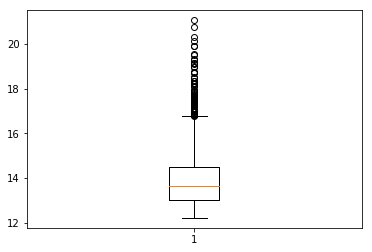

In [78]:
big_dataset2 = ps.sample(1,3000,mz_range[0][0],mz_range[0][1],rt_range[0][0],rt_range[0][1],min_ms1_intensity)

rts = [i.rt for i in big_dataset]
mzs = [i.isotopes[0][0] for i in big_dataset]
mzs2 = [i.mz for i in big_dataset2]
int = np.log([i.max_intensity for i in big_dataset])
int2 = np.log([i.intensity for i in big_dataset2])
#plt.boxplot(rts)
#np.median(rts)
#binwidth=1
#plt.hist(mzs,bins=np.arange(min(mzs), max(mzs) + binwidth, binwidth))
#print(np.median(mzs))
#print(np.median(mzs2))

plt.boxplot(int)
np.median(int)

In [44]:
big_dataset[0].isotopes[0][0]

869.6996455125027

In [33]:
max_rt = 10*60    
dia_design = "basic"
window_type = "even"
kaufmann_design = None
extra_bins = 0
num_windows=5

mass_spec = IndependentMassSpectrometer(POSITIVE, dataset, density=ps.density_estimator)
controller = TreeController(mass_spec, dia_design, window_type, kaufmann_design, extra_bins, num_windows)

set_log_level_warning() # We don't want to see too many messages as the controller is running
# set_log_level_info()
# set_log_level_debug()

controller.run(0, rt_range[0][1])

1000.1212441446963it [00:01, 888.07it/s]                                                                               


In [34]:
PROTON_MASS = 1.00727645199076

ca = Controller_Analyser(controller)
print(ca.proportion_ms1_fragmented)


mz2 = ca.list_of_ms2_mzs_dataset[0] + PROTON_MASS

times_alluting = []
for scan in controller.scans[2]:
    if mz2 in scan.mzs:
        times_alluting.append(scan.rt)
times_alluting # we know that this


1.0


[773.0910910685212, 774.4053689632048, 775.9566271274631, 776.8412512622145, 777.9182349634448, 778.7635197641818, 779.8720000682075, 780.7809743174365, 781.6965637895852, 783.013615612166, 784.120587233941, 785.1912615057842, 786.2348036568907, 787.2762572313691, 788.1231701554833, 789.590358741007, 790.3481800514637, 791.9259206467551, 792.954556028831, 793.9393053250727, 794.9655486210597, 795.9178587042596, 797.0453000945579, 798.0779113956464, 798.7499437609463, 799.7547529859805, 801.0162302823979, 801.9092083668785]

for each ms2
    loop over each ms1
        loop over scans
            does it match the allution status of the ms2
        
- base on logic that we know the exact ellution times of the chemical
- and no noise in mzs

In [46]:
ca.list_of_ms2_mzs_dataset[0]

165.68091394786302

In [49]:
number_of_possible_chemicals = []
counter = 0
for mz_dataset in ca.list_of_ms2_mzs_dataset[0:2]:
    counter += 1
    print(counter)
    if mz_dataset + PROTON_MASS not in ca.list_of_ms2_mzs_controller:
        possible_chemicals = len(controller.mass_spec.chemicals) 
        # this isnt technically accurate
        # should technically be the number of chemicals we arent sure whether have been fragmented
        number_of_possible_chemicals.append(possible_chemicals)
    else:
        possible_chemicals = 0
        allution_times = []
        for scan in controller.scans[2]:
            if mz2 in scan.mzs:
                allution_times.append(scan.rt)
        allution_times = np.array(allution_times)
        print(allution_times)
        for chem in controller.mass_spec.chemicals:
            print(chem.rt)
            chemical_rt_range = [chem.rt, chem.rt + chem.chromatogram.rts[-1]]
            if np.logical_and(chemical_rt_range[0] < allution_times,allution_times < chemical_rt_range[1]).all():
                print("here")
                scan_num = 0
                allution_status_matches = True
                while allution_status_matches and scan_num < len(controller.scans[2]):
                    # check status
                    ms2_elluting = (mz_dataset + PROTON_MASS) in controller.scans[2][scan_num].mzs
                    ms2_scan_status = controller.mass_spec._get_mz_peaks(chem, controller.scans[2][scan_num].rt, 1, controller.scans[2][scan_num].isolation_windows, 1, 1)
                    ms2_in_scan = (ms2_scan_status is not None)
                    if ms2_elluting != ms2_in_scan:
                        allution_status = False
                    scan_num += 1
                possible_chemicals += int(allution_status)
        number_of_possible_chemicals.append(possible_chemicals)

1
[773.09109107 774.40536896 775.95662713 776.84125126 777.91823496
 778.76351976 779.87200007 780.78097432 781.69656379 783.01361561
 784.12058723 785.19126151 786.23480366 787.27625723 788.12317016
 789.59035874 790.34818005 791.92592065 792.95455603 793.93930533
 794.96554862 795.9178587  797.04530009 798.0779114  798.74994376
 799.75475299 801.01623028 801.90920837]
772.276249197165
here
387.1215430535046
871.2107850796341
221.4294326093136
980.6510083164427
773.2429361846852
480.29166280675827
221.81758078401018
880.7080006736378
432.919777548435
955.6259291297836
443.3079730544807
615.3423329793908
757.5237948024279
460.536353615459
496.4807677091643
465.30083365261845
442.0921784550659
387.32322532122635
755.9266000348038
407.6139479988293
784.7326800637989
401.69374326584045
233.45710436273248
296.5751840362354
951.5663791210458
520.7669836230283
983.0555527596586
434.23578493107334
766.7927886691672
661.4681279395692
178.53584684075096
866.818420548515
671.1191740483396
695.07

In [37]:
number_of_possible_chemicals

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
int(False)

In [23]:
# only works when MS1 dont have shared MS2s
# only works when no isotopes or adducts
class Controller_Analyser(object):
    def __init__ (self, controller):
        
        # calculate observed MS2 mzs
        self.list_of_ms2_mzs_controller = []
        for scan in controller.scans[2]:
            self.list_of_ms2_mzs_controller.extend(scan.mzs.tolist())
        self.list_of_ms2_mzs_controller = np.unique(np.array(self.list_of_ms2_mzs_controller))
        
        # calculate list of all MS2 mzs
        self.list_of_ms2_mzs_dataset = []
        for chem in controller.mass_spec.chemicals:
            for child in chem.children:
                self.list_of_ms2_mzs_dataset.append(child.isotopes[0][0])
            
        # calculate observed MS1 mzs
        self.list_of_ms1_mzs_controller = []
        for scan in controller.scans[1]:
            self.list_of_ms1_mzs_controller.extend(scan.mzs.tolist())
        self.list_of_ms1_mzs_controller = np.unique(np.array(self.list_of_ms1_mzs_controller))
        
        # proportion of MS1 observed
        self.proportion_ms1_fragmented = len(self.list_of_ms1_mzs_controller) / len(controller.mass_spec.chemicals)
        
        # calculate all ms2 RTs
        self.ms2_rts = []
        for scan in controller.scans[2]:
            self.ms2_rts.append(scan.rt)
        
        # calculate rt and mz region for each ms2 mz from dataset
        

Percentage of MS2 Fragmented

In [ ]:
max_rt = 10*60    
dia_design = "basic"
window_type = "even"
kaufmann_design = None
extra_bins = 0
set_log_level_warning() # We don't want to see too many messages as the controller is running
# set_log_level_info()
# set_log_level_debug()
mass_spec = IndependentMassSpectrometer(POSITIVE, dataset, density=ps.density_estimator)

percent_id = []
for i in range(num_windows):
    num_windows=range(2,30,2)
    controller = TreeController(mass_spec, dia_design, window_type, kaufmann_design, extra_bins, num_windows[i])
    controller.run(0, max_rt)
    CA = Controller_Analyser(controller)
    percent_id.append(CA.percentage_ms2_fragmented)
    

In [ ]:
percent_id

- can scan the MS at RT of MS2 scan, gets list of MS1 peaks in RT range (already have list of MS2 peaks). Will then need scan_location to get the MS1s in MZ range (needs adding)

Assume we know which MS1 the MS2 come from

# To Do

- Convolutional neural networks to identify ROI
    - pad so all same length
    - link ROI to final peaks to see how many peaks there are
    - predict how many peaks in a ROI

- Talk to Stefan about how basic strategies in the MS would work
    - how does interact with exclusion window
    - what does it do if we see no peaks